Imports.

In [1]:
import datetime
import time
import os
import sys
sys.path.insert(0, 'utils/')

import matplotlib.pyplot as plt

import numpy as np

from scipy.integrate import quad

import numba
from numba import njit

Testing TF, GPU drivers and ROCm support.

In [2]:
import tensorflow as tf
# because of tf version many warnings will occur
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
import deepxde as dde

print('TF version: {}'.format(tf.__version__))
print('GPU support enabled: {}'.format(tf.test.is_built_with_gpu_support()))
print('ROCm support enabled: {}'.format(tf.test.is_built_with_rocm()))
print('CUDA support enabled: {}'.format(tf.test.is_built_with_cuda()))

TF version: 1.15.0
GPU support enabled: True
ROCm support enabled: False
CUDA support enabled: True


Figures configuration for journal papers.

In [3]:
from Plotting import latexconfig, figsize
latexconfig()

# Pennes' Bioheat Transfer Equation


**Ref:** Analytical Study on Bioheat Transfer Problems with Spatial or Transient Heating on Skin Surface or Inside Biological Bodies; Zhong-Shan Deng, Jing Liu; DOI: 10.1115/1.1516810

The generalized 1-D Penes equation can be written as:

$$
\rho c \frac{\partial T}{\partial t} = k \frac{\partial^2 T}{\partial x^2} + w_b \rho_b c_b(T_a - T) + Q_m + Q_r(x, t) 
$$

where $\rho, c, k$ are respectively the density, the specific heat, and the thermal conductivity of the tissue: $\rho_b, c_b$ denote density and specific heat of blood; $w_b$ the blood perfusion; $T_a$ the arterial temperature which is treated as a constant, and $T$ the tissue temperature; $Q_m$ is the metabolic heat generation, and $Q_r(x,t)$ the heat source due to spatial heating.

The initial temperature field for the basal state of biological bodies can be obtained through solving the following set of equations:

$$
\begin{equation}
  {
  k \frac{\partial^2 T}{\partial x^2} + w_b \rho_b c_b(T_a - T) + Q_m = 0;\\
  T_L(x) = T_c \hspace{10mm} x=L;\\
  -k \frac{dT_0(x)}{dx}=h_0[T_f - T_0(x)] \hspace{10mm} x=0.
  }
\end{equation}
$$

where $T_0(x)=T(x,0)$ is the steady-state temperature fields prior to heating, $T_c$ the body core temperature and often regarded as a
constant, $h_0$ the apparent heat convection coefficient between the
skin surface and the surrounding air under physiologically basal
state and is an overall contribution from natural convection and
radiation, and $T_f$ the surrounding air temperature. 
Here, the skin surface is defined at $x=0$ while the body core at $x=L$.

The boundary conditions are often time-dependant, which can be generalized as:
$$
-k\frac{\partial T}{\partial x} = f_1(t), x=0
$$
$$
-k\frac{\partial T}{\partial x} = h_f[f_2(t) - T], x=0
$$

where, $f_1(t)$ is the time-dependent surface heat flux, $f_2(t)$ the
time-dependent temperature of the cooling medium and $h_f$ the heat convection coefficient between the medium and the skin surface.

Finally, solution to the bioheat transfer equation can be expressed as:

$$
T(x,t) = T_0(x) + W(x,t) \cdot \mbox{exp}\big(-\frac{w_b \rho_b c_b}{\rho c}t\big)
$$

where

$$
T_0(x) = T_a + \frac{Q_m}{w_b \rho_b c_b} + \\
+ \frac{\big(T_c - T_a - \frac{Q_m}{w_b \rho_b c_b} \big)\cdot \big(\sqrt{A}ch(\sqrt{A}x) + \frac{h_0}{k}sh(\sqrt{A}x) \big) + \frac{h_0}{k}\big(T_f - T_a - \frac{Q_m}{w_b \rho_b c_b} \big)\cdot sh(\sqrt{A}(L-x))}{\sqrt{A}ch(\sqrt{A}L) + \frac{h_0}{k}sh(\sqrt{A}L)}
$$

and $A=\frac{w_b \rho_b c_b}{k}$

and solution for $W(x, t)$ is obtained through solving the following partial differential equation:

$$
\frac{\partial W}{\partial t} = \alpha \frac{\partial^2 W}{\partial x^2} + \frac{Q_r(x, t)}{\rho c} \cdot \mbox{exp} \big(\frac{w_b \rho_b c_b}{\rho c}t \big)
$$

using boundary and initial conditions: 

$$
\begin{equation*}
  {
  W = 0, x=L;\\
  W(x, t) = 0, t=0;\\
  -k \frac{\partial W}{\partial x}=g_1(t), x=0.
  }
\end{equation*}
$$

From that, $W(x, t)$ is defined using Green function method. 

Expression for Green function is obtained as:

$$
G_1(x, t; \xi, \tau) = \frac{2}{L}\sum_{m=1}^{\infty}e^{-\alpha \beta^2_{m}(t - \tau)} \cdot \mbox{cos}(\beta_m x) \cdot \mbox{cos}(\beta_m \xi) \cdot H(t - \tau)
$$

where $H(\cdot)$ is the Heaviside step function,

$\beta_m = \frac{2m - 1}{2L}\pi$, $m=1,2,3,...$

then the solution can be obtained as:

$$
W(x, t) = \frac{\alpha}{k}\int_0^t G_1(x, t; \xi, \tau)|_{\xi=0} \cdot g_1(\tau) d\tau + \\
+ \int_0^t d\tau \int_0^L G_1(x, t; \xi, \tau) \cdot \frac{Q_r(\xi, \tau)}{\rho c} \mbox{exp}\big(\frac{w_b \rho_b c_b}{\rho c}\tau \big)d\xi
$$

and

$$
g_1(t) = \big(k \frac{dT_0(x)}{dx}|_{x=0} + f_1(t) \big) \cdot \mbox{exp}\big(\frac{w_b \rho_b c_b}{\rho c} \big)H(t)
$$

****

In this study, time-invariant Pennes' bioheat transfer equation is solved using a novel neural network approach, where calculations were performed for no external source of heating, $Q_{ext} = 0$.

In [4]:
# consts 
c_b = 4200 
rho_b = 1e3 
om_b = 5e-4
c = 4200 
h_f = 100;
T_c = 37
L = 3e-2

# random variables
k = 0.5
w_b = c_b*rho_b*om_b
Q_m = 33800
h_0 = 10
T_f = 25
T_a = 37
rvs = [k, w_b, T_a, Q_m, h_0, T_f]
rvs = np.array(rvs).reshape(1, -1)

# solution domain
x = np.linspace(0, L, num=49)

## Analytical solution

In [5]:
def analyticSol(x):
    A = np.sqrt(w_b/k)
    lterm = (T_c - T_a - Q_m/w_b) * (A * np.cosh(A * x)  +\
                +  (h_0/k) * np.sinh(A * x)) / (A * np.cosh(A * L) + (h_0/k) * np.sinh(A * L))
    rterm = h_0/k * (T_f - T_a - Q_m/w_b) * np.sinh(A * (L * np.ones(shape=x.shape) - x)) / ( A * np.cosh(A * L) + (h_0/k) * np.sinh(A * L)) 

    return  T_a + Q_m/w_b + lterm + rterm

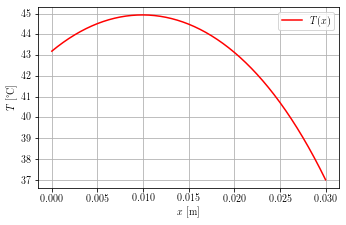

In [7]:
T_anal = analyticSol(x)

fig = plt.figure(figsize=figsize(1))
ax = fig.add_subplot(111)
ax.plot(x, T_anal, 'r-', label='$T(x)$')
ax.set_xlabel('$x$ [m]')
ax.set_ylabel('$T$ [°C]')
plt.grid()
plt.legend(loc='best')
plt.show()
fig.savefig('{}.pdf'.format('figs/analytical-solution'), bbox_inches='tight')

## Monte Carlo Uncertainty Analysis

In [8]:
@njit
def monteCarloSim(rvs, coef_var=0.2, num_samples=1000, num_iters=1000):
    sims_global = np.empty(shape=(num_iters, num_samples, rvs.shape[1]))
    for i in range(num_iters):
        xi = np.random.rand(num_samples, len(rvs)) # random values
        sims = np.zeros(shape=xi.shape)            # empty simulations matrix
        
        rvs_min = rvs - coef_var*rvs              
        rvs_max = rvs + coef_var*rvs

        sims = rvs_min + (rvs_max - rvs_min) * xi
        sims_global[i, :, :] = sims
    return sims_global

@njit
def monteCarloT(x, K, w_b, T_a, Q_m, h_0, T_f):
    A = np.sqrt(w_b/K)
    lterm = (T_c - T_a - Q_m/w_b) * (A * np.cosh(A * x)  +\
                +  (h_0/K) * np.sinh(A * x)) / (A * np.cosh(A * L) + (h_0/K) * np.sinh(A * L))
    rterm = h_0/K * (T_f - T_a - Q_m/w_b) * np.sinh(A * (L * np.ones(shape=x.shape) - x)) / ( A * np.cosh(A * L) + (h_0/K) * np.sinh(A * L)) 

    return T_a + Q_m/w_b + lterm + rterm

@njit
def monteCarloResample(x, mc):
    num_iters, num_samples, n_rv = mc.shape
    
    T_mc = np.empty(shape=(num_iters, num_samples, x.shape[0]))
    
    for it in range(num_iters):
        for sample in range(num_samples):
            T_mc[it, sample, :] = monteCarloT(x, mc[it, sample, 0], mc[it, sample, 1], mc[it, sample, 2], mc[it, sample, 3], mc[it, sample, 4], mc[it, sample, 5])
    return T_mc

In [10]:
num_samples = 100
num_iters = 100
coef_var = 0.2

start = time.time()
mc = monteCarloSim(rvs, coef_var, num_samples, num_iters)
T_mc = monteCarloResample(x, mc)
print('Simulation time: {}s'.format(time.time() - start))

Simulation time: 0.047518014907836914s


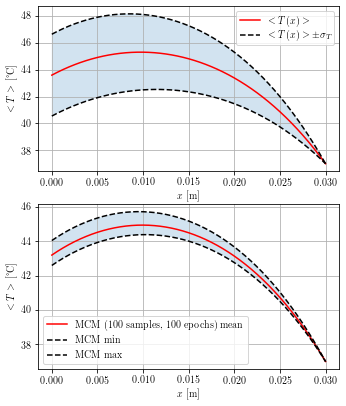

In [11]:
# single sample
_sample_exmp = 0
T_mc0 = T_mc[_sample_exmp]
T_mc0_mean = np.mean(T_mc0, axis=0)
T_mc0_std = np.std(T_mc0, axis=0)
T_mc0_lower_bound = T_mc0_mean - T_mc0_std
T_mc0_upper_bound = T_mc0_mean + T_mc0_std

fig = plt.figure(figsize=figsize(1, 2))
ax = fig.add_subplot(211)
ax.plot(x, T_mc0_mean, 'r-', label='$<T(x)>$')
ax.plot(x, T_mc0_lower_bound, 'k--', label='$<T(x)> \pm \sigma_T$')
ax.plot(x, T_mc0_upper_bound, 'k--')
ax.fill_between(x, T_mc0_lower_bound, T_mc0_upper_bound, alpha=0.2)
ax.set_xlabel('$x$ [m]')
ax.set_ylabel('$<T>$ [°C]')
plt.legend(loc='best')
# plt.title('Single MC sample')
plt.grid()

# full simulation
T_mc_mean = np.mean(T_mc, axis=1)
T_mean = np.mean(T_mc_mean, axis=0)
T_std = np.std(T_mc_mean, axis=0)
T_lower_bound = T_mc_mean[np.argmin(T_mc_mean[:, 0], axis=0)]
T_upper_bound = T_mc_mean[np.argmax(T_mc_mean[:, 0], axis=0)]

ax = fig.add_subplot(212)
ax.plot(x, T_mean, 'r-', label='MCM ({} samples, {} epochs) mean'.format(num_samples, num_iters))
ax.plot(x, T_lower_bound, 'k--', label='MCM min')
ax.plot(x, T_upper_bound, 'k--', label='MCM max')
ax.fill_between(x, T_lower_bound, T_upper_bound, alpha=0.2)
ax.set_xlabel('$x$ [m]')
ax.set_ylabel('$<T>$ [°C]')
plt.legend(loc='best')
# plt.title('MC num. of epochs: {}'.format(num_iters))
plt.grid()

fig.savefig('{}-{}epochs-{}samples.pdf'.format('figs/mc-simulation', num_iters, num_samples), bbox_inches='tight')
plt.show()

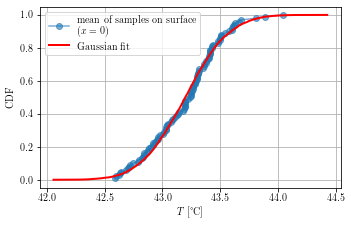

In [12]:
# distribution of sample means
def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""
    n = len(data)
    x = np.sort(data)
    y = np.arange(1, n+1) / n
    return x, y

# distribution
_exmp = 0
x_cdf, y_cdf = ecdf(T_mc_mean[:, _exmp])

# theretical gaussian distribution based on the MC simualted data
samples = np.random.normal(np.mean(T_mc_mean[:, _exmp]), np.std(T_mc_mean[:, _exmp]), 10000)
x_theor, y_theor = ecdf(samples)

fig = plt.figure(figsize=figsize(1))
ax = fig.add_subplot(111)
ax.plot(x_cdf, y_cdf, marker='o', alpha=0.6, label='mean of samples on surface \n($x=0$)')
ax.plot(x_theor, y_theor, 'r-', linewidth=2, label='Gaussian fit')
ax.set_xlabel('$T$ [°C]')
ax.set_ylabel('CDF')
plt.grid()
plt.legend(loc='best')

fig.savefig('{}.pdf'.format('figs/mc-distribution'), bbox_inches='tight')
plt.show()

## Finite Element Numerical Solution

In [13]:
def assemble_l(lhss, lhs_glob):
    if lhs_glob.shape[0]!=lhs_glob.shape[1]:
        raise Exception("Global matrix is not square matrix!") 
    else:
        for i, lhs in enumerate(lhss):
            lhs_glob[i:i+lhs.shape[0], i:i+lhs.shape[1]] += lhs
    return lhs_glob    

def assemble_r(rhss, rhs_glob):
    for i, rhs in enumerate(rhss):
        rhs_glob[i:i+rhs.shape[0], ] += rhs
    return rhs_glob

In [14]:
# domain
L = 3e-2
x = np.linspace(0, L, 100)

# fem
N = 20 # number of elements

# solution
lhs_glob = np.zeros((N+1, N+1))
T = np.zeros((N+1, 1))
rhs_glob = np.zeros((N+1, 1))

In [15]:
# base function combinations
n1 = lambda x, a, b:     (w_b*T_a + Q_m) * (b-x)/(b-a)
n2 = lambda x, a, b:     (w_b*T_a + Q_m) * (x-a)/(b-a)

nn11 = lambda x, a, b:    w_b * ((b-x)/(b-a))**2
nn12 = lambda x, a, b:    w_b * ((x-a)*(b-x))/((b-a)**2)
nn21 = lambda x, a, b:    w_b * ((x-a)*(b-x))/((b-a)**2)
nn22 = lambda x, a, b:    w_b * ((x-a)/(b-a))**2

nn_x11 = lambda x, a, b:  k/((b-a)**2)
nn_x12 = lambda x, a, b:  -k/((b-a)**2)
nn_x21 = lambda x, a, b:  -k/((b-a)**2)
nn_x22 = lambda x, a, b:  k/((b-a)**2)

In [16]:
a = 0
dx = L/N
b = dx
lhs = np.zeros((2, 2))
rhs = np.zeros((2, 1))
lhss = []
rhss = []
for i in range(N):
    print('{}. element: integration domain [{}, {}]'.format(i+1, a, b))
    lhs[0,0] = -(quad(nn11, a, b, args=(a, b))[0] + quad(nn_x11, a, b, args=(a, b))[0])
    lhs[0,1] = -(quad(nn12, a, b, args=(a, b))[0] + quad(nn_x12, a, b, args=(a, b))[0])
    lhs[1,0] = -(quad(nn21, a, b, args=(a, b))[0] + quad(nn_x21, a, b, args=(a, b))[0])
    lhs[1,1] = -(quad(nn22, a, b, args=(a, b))[0] + quad(nn_x22, a, b, args=(a, b))[0])
    lhss.append(lhs)
    
    rhs[0, 0] = -(quad(n1, a, b, args=(a, b))[0])
    rhs[1, 0] = -(quad(n2, a, b, args=(a, b))[0])
    rhss.append(rhs)
    
    a = a + dx
    b = b + dx

1. element: integration domain [0, 0.0015]
2. element: integration domain [0.0015, 0.003]
3. element: integration domain [0.003, 0.0045000000000000005]
4. element: integration domain [0.0045000000000000005, 0.006]
5. element: integration domain [0.006, 0.0075]
6. element: integration domain [0.0075, 0.009]
7. element: integration domain [0.009, 0.010499999999999999]
8. element: integration domain [0.010499999999999999, 0.011999999999999999]
9. element: integration domain [0.011999999999999999, 0.013499999999999998]
10. element: integration domain [0.013499999999999998, 0.014999999999999998]
11. element: integration domain [0.014999999999999998, 0.016499999999999997]
12. element: integration domain [0.016499999999999997, 0.018]
13. element: integration domain [0.018, 0.0195]
14. element: integration domain [0.0195, 0.021]
15. element: integration domain [0.021, 0.022500000000000003]
16. element: integration domain [0.022500000000000003, 0.024000000000000004]
17. element: integration dom

In [17]:
# assemble in global matrices
lhs_glob = assemble_l(lhss, lhs_glob)
rhs_glob = assemble_r(rhss, rhs_glob)

In [18]:
# boundary conds
# DBC
T[-1, 0] = T_c                   
lhs_glob = lhs_glob[:-1, :-1]
rhs_glob = rhs_glob[:-1, ]

# RBC
lhs_glob[0, 0] -= h_0            
rhs_glob[0, 0] -= h_0 * T_f
rhs_glob[-1, 0] -= T_c * lhs_glob[-1, -2] 

In [19]:
# T = B \ A
T[:-1, ] = np.linalg.inv(lhs_glob) @ rhs_glob

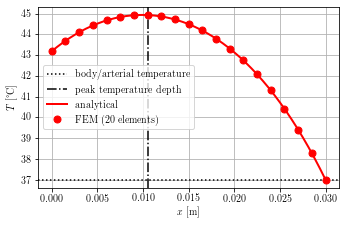

In [20]:
x_anal = np.linspace(0, L, num=T_anal.shape[0])
x = np.linspace(0, L, num=T.shape[0])

fig = plt.figure(figsize=figsize(1))
ax = fig.add_subplot(111)
ax.axhline(y=T_c, color='black', linestyle=':', label='body/arterial temperature')
ax.axvline(x=x[np.where(np.max(T)==T)[0]], color='black', linestyle='-.', label='peak temperature depth')
ax.plot(x_anal, T_anal, linewidth=2, color='red', label='analytical')
ax.plot(x, T, linestyle='None', color='red', marker='o', markersize=7, label='FEM ({} elements)'.format(N))
ax.set_xlabel('$x$ [m]')
ax.set_ylabel('$T$ [°C]')
plt.grid()
plt.legend(loc='best')
# plt.title('{} finite elements'.format(N))

fig.savefig('{}-{}felems.pdf'.format('figs/FEM', N), bbox_inches='tight')
plt.show()

## Physics Informed Neural Network

Ref 1: [Data-driven Solutions of Nonlinear Partial Differential Equations, M. Raissi et al.](https://arxiv.org/abs/1711.10561)

Ref 2: [DeepXDE: A deep learning library for solving differential equations, Lu Lu et al.](https://arxiv.org/abs/1907.04502)

Data-driven solution of time-independent PDE using Physics-informed Neural Network approach. Instead of dealing with it numerically, the solution is transformed into optimization problem:

$$
k \cdot \frac{d^2 T}{d x^2} - w_b \cdot T(x) + w_b \cdot T_a + Q_m  = 0
$$

$$ \Downarrow $$

$$
J(\theta) = [k \cdot \frac{d^2 \hat{T}}{d x^2} - w_b \cdot \hat T(x) + w_b \cdot T_a + Q_m]^2 + [\hat T(0) - T_0]^2 + [\hat T(L) - T_L]^2
$$

$$
\mbox{Optimization: } \fbox{ $\min_{\theta} J(\theta)$}
$$

where:
* $J(\theta)$ is the cost function;
* $\hat{T}(x)$ is the neural network's output for every input x and
* $T_0$ and $T_L$ are boundary conditions.


Neural network configuration:
* activation: tanh
* initializer: Glorot uniform
* architecture: input (1), 3 hidden (50), output (1)
* optimization: Adam
* metrics: l2 relative error


In [21]:
def pde(x, y):
    dy_x = tf.gradients(y, x)[0]
    dy_xx = tf.gradients(dy_x, x)[0]
    return k*dy_xx - w_b*y + (w_b*T_a + Q_m)

def boundary_l(x, on_boundary):
    return on_boundary and np.isclose(x[0], 0)

def boundary_r(x, on_boundary):
    return on_boundary and np.isclose(x[0], L)

In [22]:
geom = dde.geometry.Interval(0, L)
#bc_l = dde.RobinBC(geom, lambda x, y: (h_0/k)*y - (h_0*T_f/k), boundary_l)
bc_l = dde.DirichletBC(geom, lambda x: analyticSol(x), boundary_l)
bc_r = dde.DirichletBC(geom, lambda x: analyticSol(x), boundary_r)
data = dde.data.PDE(geom, 1, pde, [bc_l, bc_r], 20, 2, func=analyticSol, num_test=100)

layer_size = [1] + [50] * 3 + [1]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.maps.FNN(layer_size, activation, initializer)
net.outputs_modify(lambda x, y: y*10)

t = datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
new_model_path = 'model/{}'.format(t)
if not os.path.exists(new_model_path):
    os.makedirs(new_model_path)
model = dde.Model(data, net)
model.compile("adam", lr=0.001, metrics=["l2 relative error"], loss_weights=[1e-7, 1e-2, 1])
losshistory, train_state = model.train(epochs=10000, uncertainty=True)

dde.postprocessing.save_loss_history(losshistory, 'model/{}/loss.dat'.format(t))
dde.postprocessing.save_best_state(train_state, 'model/{}/train.dat'.format(t), 'model/{}/test.dat'.format(t))

Building feed-forward neural network...
'build' took 0.057367 s

Compiling model...
'compile' took 0.534635 s

Initializing variables...
Training model...

Step      Train loss                        Test loss                         Test metric   
0         [1.24e+03, 1.87e+01, 1.37e+03]    [1.24e+03, 0.00e+00, 0.00e+00]    [9.99e-01]    
1000      [1.30e+01, 1.64e+00, 9.00e-01]    [1.30e+01, 0.00e+00, 0.00e+00]    [1.41e-01]    
2000      [4.20e-02, 5.80e-01, 8.05e-05]    [3.96e-02, 0.00e+00, 0.00e+00]    [8.36e-02]    
3000      [5.02e-02, 5.48e-01, 4.81e-05]    [4.67e-02, 0.00e+00, 0.00e+00]    [8.14e-02]    
4000      [6.15e-02, 5.07e-01, 2.52e-05]    [5.66e-02, 0.00e+00, 0.00e+00]    [7.84e-02]    
5000      [7.76e-02, 4.48e-01, 1.65e-05]    [7.06e-02, 0.00e+00, 0.00e+00]    [7.38e-02]    
6000      [9.36e-02, 3.85e-01, 2.21e-04]    [8.42e-02, 0.00e+00, 0.00e+00]    [6.86e-02]    
7000      [9.47e-02, 3.31e-01, 3.19e-05]    [8.44e-02, 0.00e+00, 0.00e+00]    [6.37e-02]    
8000   

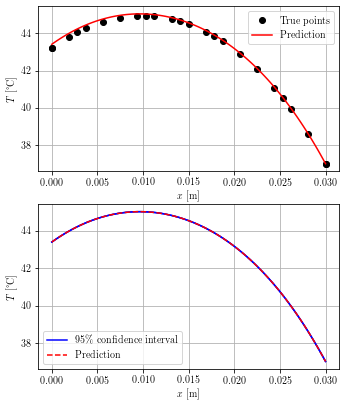

In [23]:
X_train, y_train, X_test, y_test, best_y, best_ystd = train_state.packed_data()
y_dim = y_train.shape[1]
idx = np.argsort(X_test[:, 0])
X = X_test[idx, 0]

# regression plot
fig = plt.figure(figsize=figsize(1, nplots=2))
ax = fig.add_subplot(211)
for i in range(y_dim):
    ax.plot(X_train[:, 0], y_train[:, i], 'ok', label='True points')
    ax.plot(X, best_y[idx, i], "-r", label='Prediction')
ax.set_xlabel('$x$ [m]')
ax.set_ylabel('$T$ [°C]')
plt.grid()
plt.legend(loc='best')
ax = fig.add_subplot(212)
for i in range(y_dim):
    #ax.plot(X_train[:, 0], y_train[:, i], 'ok', label='True points')
    if best_ystd is not None:
        ax.plot(X, best_y[idx, i] + 2 * best_ystd[idx, i], '-b', label='95\% confidence interval')
        ax.plot(X, best_y[idx, i] - 2 * best_ystd[idx, i], '-b')
    ax.plot(X, best_y[idx, i], "--r", label='Prediction')
ax.set_xlabel('$x$ [m]')
ax.set_ylabel('$T$ [°C]')
plt.grid()
plt.legend(loc='best')

fig.savefig('{}.pdf'.format('figs/regression'), bbox_inches='tight')
plt.show()

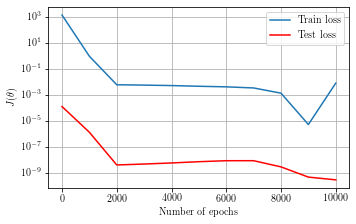

In [24]:
loss_train = np.sum(
    np.array(losshistory.loss_train) * losshistory.loss_weights, axis=1
)
loss_test = np.sum(
    np.array(losshistory.loss_test) * losshistory.loss_weights, axis=1
)

fig = plt.figure(figsize=figsize(1))
ax = fig.add_subplot(111)
ax.semilogy(losshistory.steps, loss_train, color='C0', label="Train loss")
ax.semilogy(losshistory.steps, loss_test, color='red', label="Test loss")
#for i in range(len(losshistory.metrics_test[0])):
    #ax.semilogy(losshistory.steps, np.array(losshistory.metrics_test)[:, i], color='black', label="Test metric",)
ax.set_xlabel('Number of epochs')
ax.set_ylabel(r'$J(\theta)$')
plt.grid()
plt.legend(loc='best')

fig.savefig('{}.pdf'.format('figs/loss'), bbox_inches='tight')
plt.show()

In [25]:
# random variables
rvs = [k, w_b, T_a, Q_m, h_0]
rvs = np.array(rvs).reshape(1, -1)
num_samples = 5
num_iters = 5
rvs_data = monteCarloSim(rvs, coef_var=0.2, num_samples=num_samples, num_iters=num_iters)
rvs_data.shape

(5, 5, 5)

In [26]:
# train_state_ensemble = []
# for epoch in range(num_iters):
#     train_state_full = []
#     for sample in range(num_samples):
#         k = rvs_data[epoch, sample, 0]
#         w_b = rvs_data[epoch, sample, 1]
#         T_a = rvs_data[epoch, sample, 2]
#         Q_m = rvs_data[epoch, sample, 3]
#         h_0 = rvs_data[epoch, sample, 4]

#         geom = dde.geometry.Interval(0, L)
#         bc_l = dde.DirichletBC(geom, lambda x: analyticSol(x), boundary_l)
#         bc_r = dde.DirichletBC(geom, lambda x: analyticSol(x), boundary_r)
#         data = dde.data.PDE(geom, 1, pde, [bc_l, bc_r], 50, 2, func=analyticSol, num_test=100)

#         layer_size = [1] + [50] * 3 + [1]
#         activation = "tanh"
#         initializer = "Glorot uniform"
#         net = dde.maps.FNN(layer_size, activation, initializer)
#         net.outputs_modify(lambda x, y: y*10)

#         model = dde.Model(data, net)
#         model.compile("adam", lr=0.001, metrics=["l2 relative error"], loss_weights=[1e-7, 1e-2, 1])
#         losshistory, train_state = model.train(epochs=10000, uncertainty=True, display_every=10000)
#         train_state_full.append(train_state)
#     train_state_ensemble.append(train_state_full)

# X_train = np.zeros(shape=(num_iters, num_samples, 54))
# y_train = np.zeros(shape=(num_iters, num_samples, 54))
# X_test = np.zeros(shape=(num_iters, num_samples, 100))
# y_test = np.zeros(shape=(num_iters, num_samples, 100))
# best_y = np.zeros(shape=(num_iters, num_samples, 100))
# best_ystd = np.zeros(shape=(num_iters, num_samples, 100))

# for i, train_state_full in enumerate(train_state_ensemble):
#     for j, train_state in enumerate(train_state_full):
#         unpacked = train_state.packed_data()
#         X_train[i, j, :] = unpacked[0].ravel()
#         y_train[i, j, :] = unpacked[1].ravel()
#         X_test[i, j, :] = unpacked[2].ravel()
#         y_test[i, j, :] = unpacked[3].ravel()
#         best_y[i, j, :] = unpacked[4].ravel()
#         best_ystd[i, j, :] = unpacked[5].ravel()

# np.save('data/X_train.npy', X_train)
# np.save('data/y_train.npy', y_train)
# np.save('data/X_test.npy', X_test)
# np.save('data/y_test.npy', y_test)
# np.save('data/best_y.npy', best_y)
# np.save('data/best_ystd.npy', best_ystd)

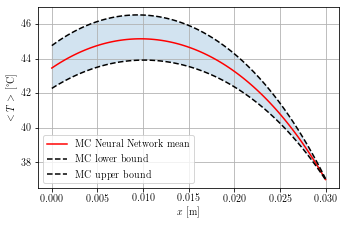

In [27]:
X_train = np.load('data/X_train.npy')
y_train = np.load('data/y_train.npy')
X_test = np.load('data/X_test.npy')
y_test = np.load('data/y_test.npy')
best_y = np.load('data/best_y.npy')
best_ystd = np.load('data/best_ystd.npy')

best_y_mc_mean = np.mean(best_y, axis=1)
best_y_mean = np.mean(best_y_mc_mean, axis=0)
best_y_std = np.std(best_y_mean, axis=0)
best_y_lower_bound = best_y_mc_mean[np.argmin(best_y_mc_mean[:, 0], axis=0)]
best_y_upper_bound = best_y_mc_mean[np.argmax(best_y_mc_mean[:, 0], axis=0)]

fig = plt.figure(figsize=figsize(1))
ax = fig.add_subplot(111)
ax.plot(X, best_y_mean, 'r-', label='MC Neural Network mean')
ax.plot(X, best_y_lower_bound, 'k--', label='MC lower bound')
ax.plot(X, best_y_upper_bound, 'k--', label='MC upper bound')
ax.fill_between(X, best_y_lower_bound, best_y_upper_bound, alpha=0.2)
ax.set_xlabel('$x$ [m]')
ax.set_ylabel('$<T>$ [°C]')
plt.legend(loc='best')
plt.grid()
fig.savefig('{}.pdf'.format('figs/uncertainty-mcnn-{}epochs{}samples'.format(num_iters, num_samples)), bbox_inches='tight')
plt.show()